In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
from pySankey.sankey import sankey
import textwrap
from matplotlib.ticker import MaxNLocator
pd.set_option('display.max_rows', 500)

### Import table

In [2]:
file_name = 'WG 2 Systematic Review - Audio.xlsx'
data_sheet = 'Data extraction All search resu'

In [3]:
# read excel file
df = pd.read_excel(file_name,
                   sheet_name = data_sheet,
                   header=1)

### Clean data

In [4]:
import pandas as pd

# Create a dictionary for each column
fix_dict = {
    'Clinical population': {
        'deaf/hard of hearing': 'Hearing loss',
        'ASD': 'Autism',
        'stuttering': 'Speech fluency disorder',
        'Neurodevelopmental Disorder': 'Various neurodevelopmental disorders',
        'language impairment': 'Language disorder/delay',
        'speech disorders/speech delay': 'Speech sound disorders'
    },

    'Country specify': {
        'USA': 'United States of America',
        'Korea': 'South Korea',
        'England': 'UK',
        'United Kingdom': 'UK',
        'The Uk': 'UK',
        'Scotland': 'UK',
        'Swedish': 'Sweden',
        'Hong Kong': 'China',
        'The Netherlands': 'Netherlands',
        'the Netherlands': 'Netherlands',
        'UK': 'United Kingdom',
        'Portugal (assumed)': 'Portugal',
        'Papa New G': 'Papua New Guinea',
        'Slovenian': 'Slovenia',
        'Chine': 'China',
        'The Gambia': 'Gambia'
    },

    'Language of the participants other': {
        'Norweigen': 'Norwegian',
        'Brazilian Portoguese': 'Portuguese'
    }, 

    'Language of the participants': {
        'Other fill manually': 'Other'
    },

    'Recording equipment': {
        'voice recorders/microphone somewhere in the room': 'Microphone or voice recorder',
        'multiple audio recording devices used at once': 'Microphone or voice recorder',
        'wearable microphone on child': 'Microphone or voice recorder',
        'wearable microphone on parent': 'Microphone or voice recorder',
        'audio+video recordings': 'Camera'
    },
                      
    'Automatic tools': {
        'LENA ': 'LENA'
    },
    
    'Population studied': {
        ' - specify': ''
    }
}

# Apply replacements efficiently
for col, mapping in fix_dict.items():
    if col in df.columns:
        df[col] = df[col].replace(mapping)

In [5]:
# capitalize values
col_list = ['Language of the participants',
            'Clinical population', 
            'Settings of the audio recordings', 
            'Duration of the recorded samples']

for col in col_list:
    df[col] = df[col].str.capitalize()

In [6]:
# additional data processing

# revert to NICU after capitalization
df['Settings of the audio recordings'] = df['Settings of the audio recordings'].str.replace('Nicu', 'NICU')

# change "Nursey/presch" to "Nursey/preschool"
col = 'Settings of the audio recordings'
rows_to_change = df[col].str.contains('Nursery/presch', na = False)
df.loc[rows_to_change, col] = 'Nursery/preschool'

# change 'language' to English if English is present in 'other language' description 
rows_to_change = df['Language of the participants other'].str.contains('English', na=False)
df.loc[rows_to_change, 'Language of the participants'] = 'English'

In [15]:
# get list of all other languages 
df['Language of the participants other'] = df['Language of the participants other'].str.replace('(USA, Canada & British)', '')
df['Language of the participants other (split)'] = df['Language of the participants other'].str.split(',') # split strings by ',' and store in list
df_other_langs_expanded = df.explode('Language of the participants other (split)') # transform each element list to a row, replicating index values
df_other_langs_expanded['Language of the participants other (split)'] = df_other_langs_expanded['Language of the participants other (split)'].str.strip() # remove leading and trailing whitespace

col = 'Language of the participants other (split)'
common_langs = ['Mandarin', 'Cantonese', 'Portuguese', 'Spanish', 'French', 'Dutch', 'English']

for lang in common_langs:
    rows_to_change = df_other_langs_expanded[col].str.contains(lang, na=False)
    df_other_langs_expanded.loc[rows_to_change, col] = lang

mapping = {'Shaanxi dialect': 'Mandarin', 'Yeli Dyne': 'Yélî Dnye', 'Multiple indigenous languages': 'remove', 'tsmiane':'Tsimane', 'Finish': 'Finnish', 'Tsetal':'Tseltal'}
df_other_langs_expanded['Language of the participants other (split)'] = df_other_langs_expanded['Language of the participants other (split)'].replace(mapping)
df_other_langs_expanded = df_other_langs_expanded[~df_other_langs_expanded['Language of the participants other (split)'].isin(['English', 'remove'])]

### Plotting functions

In [56]:
def bar_chart(df, col, wrap = False, alt_title = None, wrap_width = 10, custom_order = None, labelsize = 8.5):

    # data 
    counts = df[col].value_counts().reset_index()
    if custom_order != None:
        counts = counts.iloc[custom_order]

    # colors
    palette = sns.color_palette('flare', n_colors=counts.shape[0])
    palette.reverse()
    hex_codes = list(palette.as_hex())

    # plot
    fig, ax = plt.subplots()
    bars = ax.bar(counts[col], counts['count'], color=palette)
    ax.set_ylabel('Number of publications')
    ax.tick_params(axis = 'x', labelsize = labelsize)
    ax.set_title(col)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * 1.1)

    # add numbers at top 
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    # if chart title is different from column name
    if alt_title != None:
        ax.set_title(alt_title)

    # x tick labels 
    ticks = ax.get_xticklabels()
    labels = [x.get_text() for x in ticks]
    tick_pos = [x.get_position()[0] for x in ticks]
    if wrap: # labels horizontal and wrapped
        ang = 0
        pos = 'center'
        new_labels = [textwrap.fill(label, width=wrap_width) for label in labels]
    else: # labels at 45deg angle
        ang = 45
        pos = 'right'
        new_labels = labels
    ax.set_xticks(tick_pos, new_labels, rotation = ang, ha = pos)

    # save plot
    name = col.replace(' ', '_')
    fig.savefig(f'plots/barchart_{name}', dpi = 300, bbox_inches='tight')

    return hex_codes, counts

In [67]:
# pie chart functions
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n(n={absolute:d})"

def pie_chart(df, col):

    # data
    counts = df[col].value_counts().reset_index()

    # colors
    palette = sns.color_palette('flare', n_colors=counts.shape[0])
    palette.reverse()

    # plot
    fig, ax = plt.subplots()
    _, _, autotexts = ax.pie(counts['count'],
            labels = counts[col],
            colors=palette,
            startangle=90,
            autopct=lambda pct: func(pct, counts['count']),
            pctdistance=0.75
            )
    ax.set_title(col)

    # make text inside pie white
    for autotext in autotexts:
        autotext.set_color('white')

    # save plot
    name = col.replace(' ', '_')
    fig.savefig(f'plots/piechart_{name}', dpi = 300, bbox_inches='tight')

    return counts

### Bar charts

,Recording equipment,count
0,LENA,141
1,Microphone or voice recorder,41
2,Camera,12


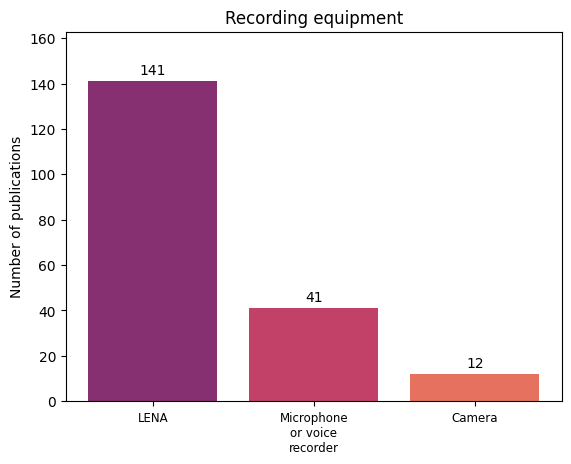

In [57]:
RE_colors, RE_counts = bar_chart(df, 'Recording equipment', True)
RE_counts

,Automatic tools,count
0,LENA,122
1,Other tools for acoustic analysis,35
2,Praat,26
3,Speech detection algorithms,6
4,openSMILE,3
5,ALICE,2


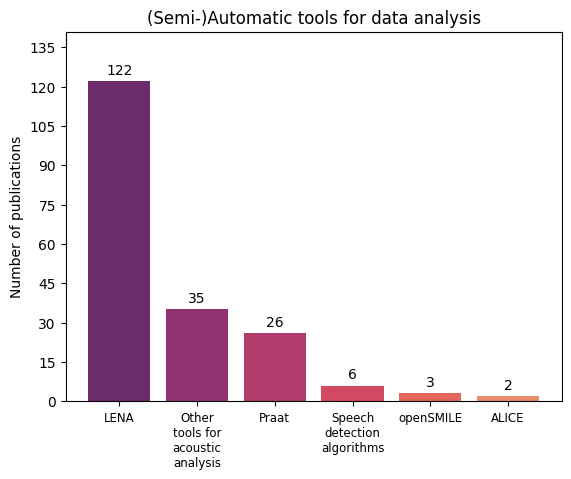

In [58]:
_, AT_counts = bar_chart(df, 'Automatic tools', wrap = True, alt_title='(Semi-)Automatic tools for data analysis')
AT_counts

,Settings of the audio recordings,count
0,Home,143
1,Lab,28
2,Nursery/preschool,12
3,NICU,5
4,Various,4


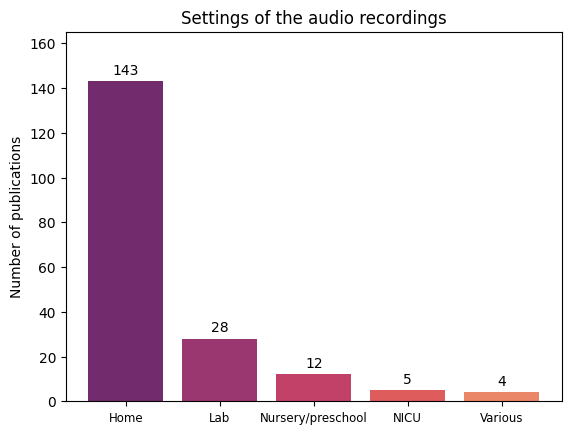

In [59]:
_, counts = bar_chart(df, 'Settings of the audio recordings', True, wrap_width=20)
counts

,Clinical population,count
0,Hearing loss,23
1,Autism,19
2,Preterm,6
3,Cleft palate,5
4,Rett syndrome,2
5,Speech sound disorders,2
6,Cerebral palsy,2
7,Psychopathology general,2
8,Language disorder/delay,2
9,Down syndrome,2


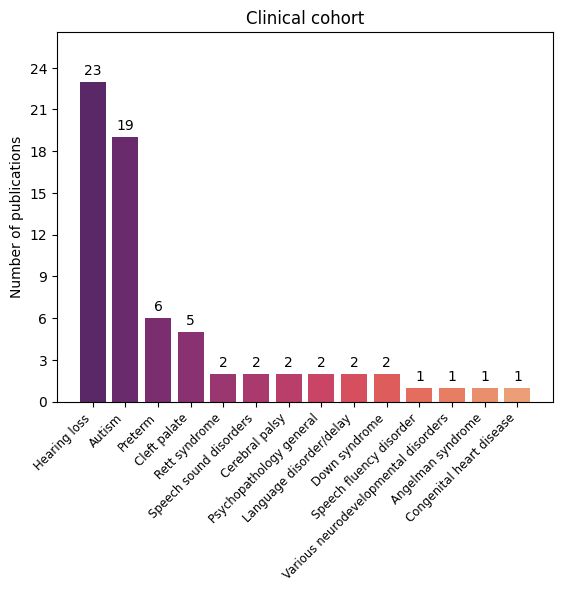

In [60]:
_, counts = bar_chart(df, 'Clinical population', alt_title = 'Clinical cohort')
counts

,Language of the participants other (split),count
0,Spanish,21
1,French,10
2,Mandarin,9
3,Korean,6
4,Portuguese,4
5,Swedish,4
6,Dutch,4
7,Finnish,4
8,Tseltal,3
9,Yélî Dnye,3


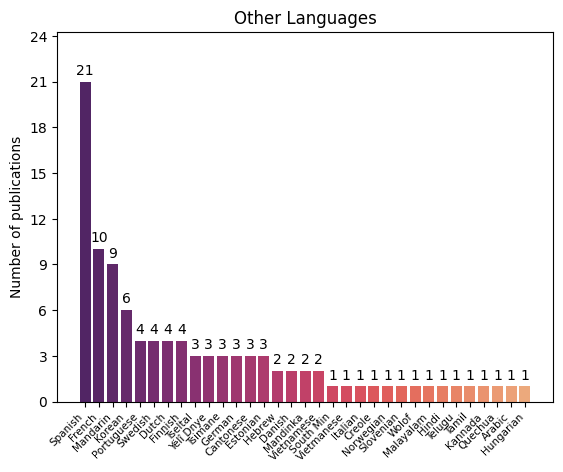

In [61]:
_, counts = bar_chart(df_other_langs_expanded, 'Language of the participants other (split)', alt_title='Other Languages', labelsize = 7.5)
counts

,Duration of the recorded samples,count
0,Daylong,132
2,Hours,27
1,Minutes,33


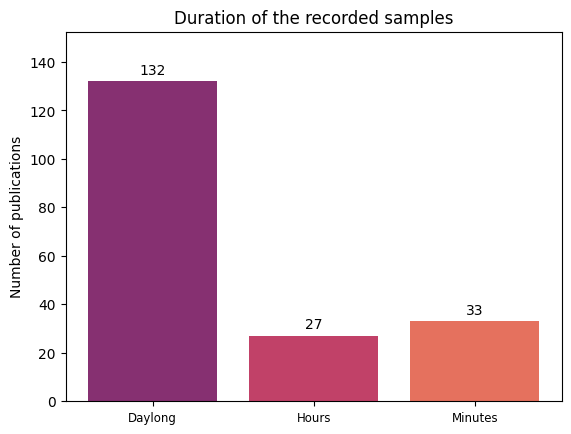

In [62]:
_, counts = bar_chart(df, 'Duration of the recorded samples', wrap = True, custom_order=[0,2,1])
counts

### Sankey diagram

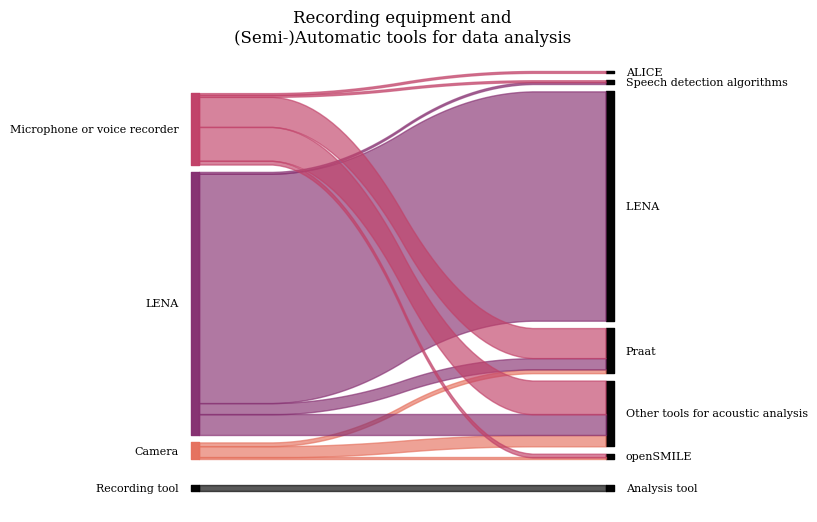

In [103]:
# colors
cols = list(RE_counts.iloc[:,0].values) + list(AT_counts.replace({'LENA': 'LENA '}).iloc[:,0].values)
colors = RE_colors + ['k']*AT_counts.shape[0]
colorDict  = dict(zip(cols, colors))
colorDict['Recording tool'] = 'k'
colorDict['Analysis tool'] = 'k'
colorDict[''] = 'w'

df_sankey = df[(~df['Recording equipment'].isna()) & (~df['Automatic tools'].isna())]

# add rows for space above labels
new_row = {'Recording equipment': '', 'Automatic tools': ''}
new_rows = pd.DataFrame([new_row] * 6)
df_sankey = pd.concat([new_rows, df_sankey], ignore_index=True)

# add rows for labels
new_row = {'Recording equipment': 'Recording tool', 'Automatic tools': 'Analysis tool'}
new_rows = pd.DataFrame([new_row] * 3)
df_sankey = pd.concat([new_rows, df_sankey], ignore_index=True)

# plot
sankey(df_sankey['Recording equipment'], df_sankey['Automatic tools'].replace({'LENA': 'LENA '}), colorDict=colorDict, fontsize=8)
plt.title('Recording equipment and\n(Semi-)Automatic tools for data analysis')
plt.savefig(f'plots/sankey_plot_new.png', dpi = 300, bbox_inches='tight')
plt.rc('font', family='DejaVu Sans')

### Pie charts

,Language of the participants,count
0,English,114
1,Other,48
2,Multiple languages,9


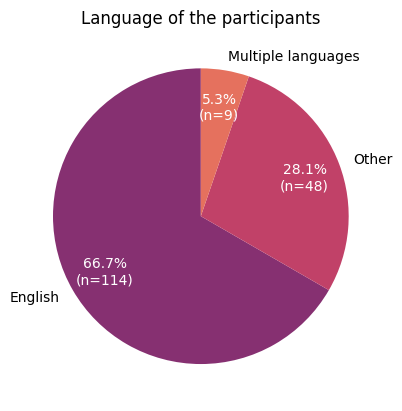

In [68]:
pie_chart(df, 'Language of the participants')

,Setting,count
0,Naturalistic,155
1,Structured assessment,28
2,"Semi-naturalistic (e.g., free play in the lab)",10


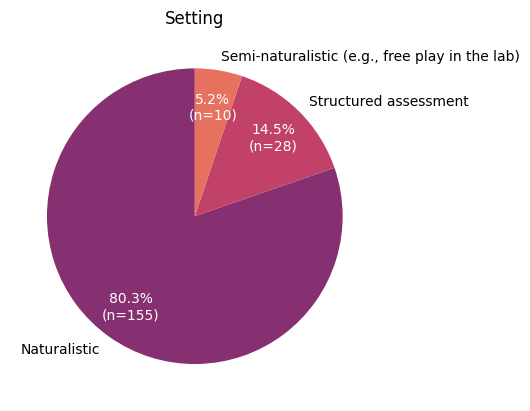

In [69]:
pie_chart(df, 'Setting')

,Population studied,count
0,General population,127
1,Clinical population - specify,69


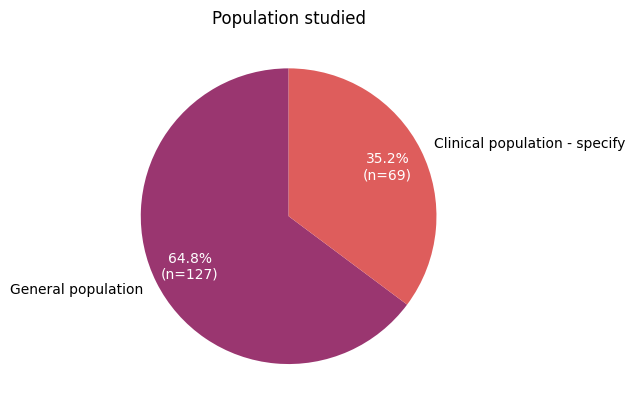

In [70]:
pie_chart(df, 'Population studied')

### World map

In [231]:
# transform dataframe to account for multiple countries in a singel publication
df['Country'] = df['Country specify'].str.split(',') # split strings by ',' and store in list
df_expanded = df.explode('Country') # transform each element list to a row, replicating index values
df_expanded['Country'] = df_expanded['Country'].str.strip() # remove leading and trailing whitespace

counts = df_expanded['Country'].value_counts().reset_index().rename(columns = {'count': 'count_publications'})

In [232]:
# retrieve GeoDataFrame
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
geo_df = gpd.read_file(url)
geo_df.rename(columns = {'ADMIN': 'Country'}, inplace = True)

In [234]:
# test joins
merge_test = geo_df.merge(counts, how = 'right', on = 'Country')
n = merge_test[merge_test['geometry'].isna()].shape[0]
print(f'Number of countries in publication dataset that were not matched: {n}')

Number of countries in publication dataset that were not matched: 0


In [235]:
df_map = geo_df.merge(counts, how = 'left', on = 'Country')
df_map = df_map[df_map['Country'] != 'Antarctica']
df_map = df_map.to_crs(epsg=3857)

In [237]:
df_map.value_counts(['count_publications']).reset_index()

,count_publications,count
0,2.0,14
1,1.0,10
2,3.0,5
3,4.0,2
4,5.0,2
5,11.0,2
6,6.0,1
7,8.0,1
8,13.0,1
9,99.0,1


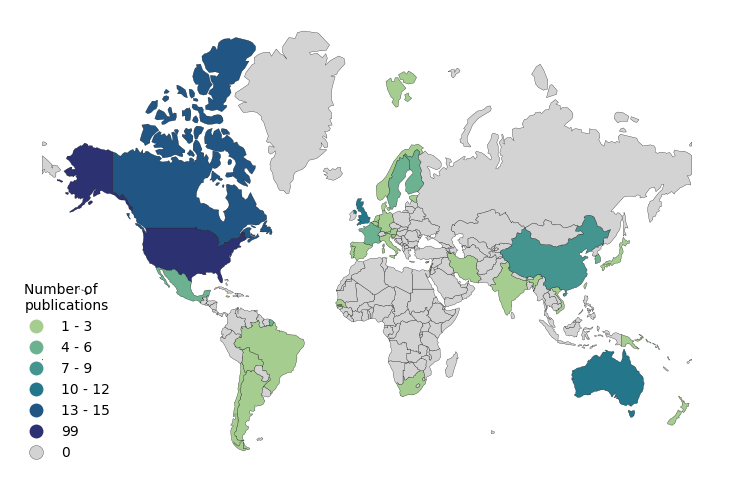

In [239]:
# plot
figsize = (15,6)
border_color = 'black'
border_linewidth = 0.3
shaded_colors = 'crest'
plot_title = ''

# create canvas to plot multiple things onto
fig, ax = plt.subplots(1,1, figsize = figsize)

# shaded countries
df_map.plot(column = 'count_publications',
                    cmap = shaded_colors,
                    legend = True,
                    legend_kwds = {"labels": ['1 - 3', '4 - 6', '7 - 9', '10 - 12', '13 - 15', '99']},
                    missing_kwds={"color": "lightgrey", "edgecolor": "k", 'linewidth': 0.2, "label": "0"},
                    scheme = 'User_Defined',
                    edgecolor = 'k',
                    linewidth = 0.2,
                    classification_kwds=dict(bins=[3,6,9,12,15,100]),
                    ax=ax) 

legend = ax.get_legend()
legend.set_title("Number of\npublications")
legend.set_frame_on(False)
legend.set_loc('lower left')

ax.set_title(plot_title)
ax.set_axis_off() # remove axis

In [721]:
fig.savefig(f'plots/worldmap', dpi = 500, bbox_inches='tight')